# Importing libraries

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('data_processing').getOrCreate()

# Importing Data

In [2]:
# Load training data
df = spark.read.option("header",True).csv("./data/creditcard.csv")

df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
df.count()

6362620

In [4]:
len(df.columns)

11

In [5]:
from pyspark.sql.functions import col
df = df.limit(1000000)

# Data Pre-processing 

In [6]:
df.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

In [7]:
from pyspark.sql.types import DoubleType

df = df.withColumn("amount", df.amount.cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df.oldbalanceOrg.cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df.newbalanceOrig.cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df.oldbalanceDest.cast(DoubleType()))
df = df.withColumn("newbalanceDest", df.newbalanceDest.cast(DoubleType()))
df = df.withColumn("isFraud", df.isFraud.cast('int'))

In [8]:
df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [9]:
data = df.drop('step', 'isFlaggedFraud')

In [10]:
# Input variables : step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest
# Output Variable : isFraud

# EDA : Feature Engineering 

In [11]:
df.describe().show()

+-------+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+-------------------+--------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|            isFraud|isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+------------------+-----------+------------------+------------------+-------------------+--------------+
|  count|           1000000| 1000000|           1000000|    1000000|           1000000|           1000000|    1000000|           1000000|           1000000|            1000000|       1000000|
|   mean|         25.156387|    null|160249.92230851384|       null| 877670.2866646429| 898346.4869360499|       null| 986066.8063540653|1125661.8185545737|            5.35E-4|           0.0|
| stddev|12.652099832907444|    null|259

In [12]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'double' or t[1]=='int']
df.select(numeric_features).describe().toPandas()

,summary,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,count,1000000,1000000,1000000,1000000,1000000,1000000
1,mean,160249.92230851384,877670.2866646429,898346.4869360499,986066.8063540653,1125661.8185545737,5.35E-4
2,stddev,259258.44779519632,2982419.5231673685,3019325.9395476882,2305423.0755312582,2426587.034775223,0.02312389045369133
3,min,0.1,0.0,0.0,0.0,0.0,0
4,max,1.0E7,3.893942403E7,3.894623302E7,4.205465973E7,4.216915609E7,1


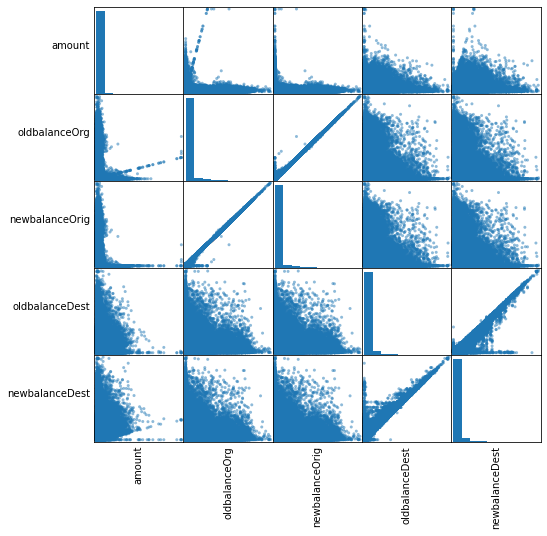

In [13]:
import pandas as pd
from pandas.plotting import scatter_matrix

numeric_features = ['amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = data.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [14]:
data = df

# Apply OneHotEncoder to type, nameOrig and nameDesr column

In [15]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

## type column

In [16]:
from pyspark.ml.feature import StringIndexer
type_indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
#Fits a model to the input dataset with optional parameters.
data = type_indexer.fit(data).transform(data)
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|      1.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|      1.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|      3.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|      0.0|
|   1| PAYMEN

## nameOrig column

In [17]:
nameOrig_indexer = StringIndexer(inputCol="nameOrig", outputCol="nameOrigIndex")
#Fits a model to the input dataset with optional parameters.
data = nameOrig_indexer.fit(data).transform(data)
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|nameOrigIndex|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|      1.0|     119517.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|      1.0|     344711.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|      3.0|     157686.0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38

## nameOrig column

In [18]:
nameDest_indexer = StringIndexer(inputCol="nameDest", outputCol="nameDestIndex")
#Fits a model to the input dataset with optional parameters.
data = nameDest_indexer.fit(data).transform(data)
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-------------+-------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|nameOrigIndex|nameDestIndex|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-------------+-------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|      1.0|     119517.0|     260240.0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|      1.0|     344711.0|     271266.0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|      3.0|     157686.0| 

In [19]:
data = data.drop('type', 'nameOrig', 'nameDest')

In [20]:
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+--------------+---------+-------------+-------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|nameOrigIndex|nameDestIndex|
+----+--------+-------------+--------------+--------------+--------------+-------+--------------+---------+-------------+-------------+
|   1| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|      1.0|     119517.0|     260240.0|
|   1| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|      1.0|     344711.0|     271266.0|
|   1|   181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|      3.0|     157686.0|       2876.0|
|   1|   181.0|        181.0|           0.0|       21182.0|           0.0|      1|             0|      0.0|     917174.0|       2454.0|
|   1|11668.14|      41554.0|      29885.86|    

## label column

In [21]:
from pyspark.ml.feature import StringIndexer
data = StringIndexer(  inputCol="isFraud", outputCol="label").fit(data).transform(data)

In [22]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'oldbalanceDest', 
                                       'newbalanceDest', 'typeIndex','nameOrigIndex',
                                       'nameDestIndex'], outputCol='features')
data = assembler.transform(data)

In [23]:
data.show(5)

+----+--------+-------------+--------------+--------------+--------------+-------+--------------+---------+-------------+-------------+-----+--------------------+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|nameOrigIndex|nameDestIndex|label|            features|
+----+--------+-------------+--------------+--------------+--------------+-------+--------------+---------+-------------+-------------+-----+--------------------+
|   1| 9839.64|     170136.0|     160296.36|           0.0|           0.0|      0|             0|      1.0|     119517.0|     260240.0|  0.0|[9839.64,170136.0...|
|   1| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      0|             0|      1.0|     344711.0|     271266.0|  0.0|[1864.28,21249.0,...|
|   1|   181.0|        181.0|           0.0|           0.0|           0.0|      1|             0|      3.0|     157686.0|       2876.0|  1.0|[181.0,181.0,0.0,...|
|   1|   181.0|       

In [24]:
data_train, data_test = data.randomSplit([0.8, 0.2], seed=23)

In [25]:
[data_train.count(), data_test.count()]

[799338, 200662]

In [55]:
results = {}

# Logestic Regression :

In [26]:
from pyspark.ml.classification import LogisticRegression
#Create a Logistic Regression classifier.
logistic = LogisticRegression()
# Learn from the training data.
logistic = logistic.fit(data_train)

In [27]:
prediction_LR = logistic.transform(data_test)

In [28]:
prediction_LR.groupBy("label", "prediction").count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|200561|
|  1.0|       0.0|    93|
|  0.0|       1.0|     3|
|  1.0|       1.0|     5|
+-----+----------+------+



In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
evaluator.evaluate(prediction_LR, {evaluator.metricName: 'weightedPrecision'})

0.9993535981580794

In [30]:
logistic.coefficients

DenseVector([0.0, -0.0, 0.0, -0.0, -0.0077, -0.0, -0.0])

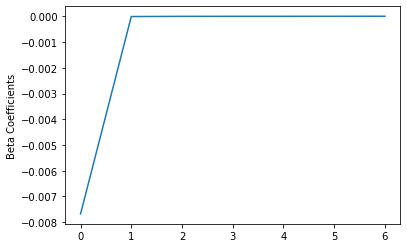

In [31]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(logistic.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [56]:
results['Logestic Regression'] = evaluator.evaluate(prediction_LR, {evaluator.metricName: 'weightedPrecision'})

# Decision Tree Classifier :

In [32]:
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [33]:
# Split our dataset between training and test datasets
(train, test) = df.randomSplit([0.8, 0.2], seed=123)

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

# Encodes a string column of labels to a column of label indices
indexer = StringIndexer(inputCol = "type", outputCol = "typeIndexed")

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
va = VectorAssembler(inputCols = ["typeIndexed", "amount", "oldbalanceOrg", "newbalanceOrig", 
                                  "oldbalanceDest", "newbalanceDest"], outputCol = "features")

# Using the DecisionTree classifier model
dt = DecisionTreeClassifier(labelCol = "isFraud", featuresCol = "features", seed = 54321, maxDepth = 5)

# Create our pipeline stages
dt_pipeline = Pipeline(stages=[indexer, va, dt])

# View the Decision Tree model (prior to CrossValidator)
dt_model = dt_pipeline.fit(train)

In [35]:
# Make predictions.
dt_predictions = dt_model.transform(test)

In [36]:
# Select example rows to display.
dt_predictions.select('features', 'rawPrediction', 'probability', 'prediction').show(5)

+--------------------+--------------+-----------+----------+
|            features| rawPrediction|probability|prediction|
+--------------------+--------------+-----------+----------+
|[2.0,783.31,81503...|[443445.0,0.0]|  [1.0,0.0]|       0.0|
|[2.0,1271.77,6973...|[443445.0,0.0]|  [1.0,0.0]|       0.0|
|[2.0,5763.99,1276...|[443445.0,0.0]|  [1.0,0.0]|       0.0|
|[2.0,6284.18,7858...|[443445.0,0.0]|  [1.0,0.0]|       0.0|
|[2.0,8261.33,6501...|[443445.0,0.0]|  [1.0,0.0]|       0.0|
+--------------------+--------------+-----------+----------+
only showing top 5 rows



In [37]:
dt_predictions.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|200461|
|      1|       0.0|    53|
|      1|       1.0|    61|
|      0|       1.0|    16|
+-------+----------+------+



In [38]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)
print("Test Error = %g " % (1.0 - accuracy))

dtModel = dt_model.stages[2]
# summary only
print(dtModel)

Test Error = 0.000343984 
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ae6195d0abff, depth=5, numNodes=21, numClasses=2, numFeatures=6


In [39]:
evaluator.evaluate(dt_predictions, {evaluator.metricName: 'weightedPrecision'})

0.9996177369282643

In [58]:
results['Decision Tree Classifier'] = evaluator.evaluate(dt_predictions, {evaluator.metricName: 'weightedPrecision'})

# Random Forest Classifier :

In [40]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=10)

# Create our pipeline stages
rf_pipeline = Pipeline(stages=[indexer, va, rf])

# View the Decision Tree model (prior to CrossValidator)
rf_model = rf_pipeline.fit(train)

In [41]:
# Make predictions.
rf_predictions = rf_model.transform(test)

In [42]:
rf_predictions.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|200477|
|      1|       0.0|    82|
|      1|       1.0|    32|
+-------+----------+------+



In [43]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print("Test Error = %g " % (1.0 - accuracy))

rfModel = rf_model.stages[2]
print(rfModel)  # summary only

Test Error = 0.000408792 
RandomForestClassificationModel: uid=RandomForestClassifier_42bea6ffe925, numTrees=10, numClasses=2, numFeatures=6


In [44]:
evaluator.evaluate(rf_predictions, {evaluator.metricName: 'weightedPrecision'})

0.9995913751179965

In [59]:
results['Random Forest Classifier'] = evaluator.evaluate(rf_predictions, {evaluator.metricName: 'weightedPrecision'})

# Gradient-Boosted Tree Classifier

In [45]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

# Chain indexers and GBT in a Pipeline
gbt_pipeline = Pipeline(stages=[indexer, va, gbt])

# Train model.  This also runs the indexers.
gbt_model = gbt_pipeline.fit(train)

In [46]:
# Make predictions.
gbt_predictions = gbt_model.transform(test)

In [47]:
gbt_predictions.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|200463|
|      1|       0.0|    53|
|      1|       1.0|    61|
|      0|       1.0|    14|
+-------+----------+------+



In [48]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbt_predictions)
print("Test Error = %g " % (1.0 - accuracy))

gbtModel = gbt_model.stages[2]
print(gbtModel)  # summary only

Test Error = 0.000334013 
GBTClassificationModel: uid = GBTClassifier_83bb03deb71a, numTrees=10, numClasses=2, numFeatures=6


In [49]:
evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'weightedPrecision'})

0.9996297456436446

In [60]:
results['Gradient-Boosted Tree Classifier'] = evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'weightedPrecision'})

# Support Vector Machine : SVM 

In [50]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(labelCol="isFraud", featuresCol="features", maxIter=10, regParam=0.1)


# Chain indexers and GBT in a Pipeline
lsvc_pipeline = Pipeline(stages=[indexer, va, gbt])

# Train model.  This also runs the indexers.
lsvc_model = lsvc_pipeline.fit(train)

In [51]:
# Make predictions.
lsvc_predictions = lsvc_model.transform(test)

In [52]:
lsvc_predictions.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|200463|
|      1|       0.0|    53|
|      1|       1.0|    61|
|      0|       1.0|    14|
+-------+----------+------+



In [53]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lsvc_predictions)
print("Test Error = %g " % (1.0 - accuracy))

lsvcModel = lsvc_model.stages[2]
print(lsvcModel)  # summary only

Test Error = 0.000334013 
GBTClassificationModel: uid = GBTClassifier_83bb03deb71a, numTrees=10, numClasses=2, numFeatures=6


In [54]:
evaluator.evaluate(lsvc_predictions, {evaluator.metricName: 'weightedPrecision'})

0.9996297456436446

In [61]:
results['SVM'] = evaluator.evaluate(lsvc_predictions, {evaluator.metricName: 'weightedPrecision'})

In [62]:
results

{'Logestic Regression': 0.9993535981580794,
 'Decision Tree Classifier': 0.9996177369282643,
 'Random Forest Classifier': 0.9995913751179965,
 'Gradient-Boosted Tree Classifier': 0.9996297456436446,
 'SVM': 0.9996297456436446}

# Naive Bayes

In [75]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# create the trainer and set its parameters
nb = NaiveBayes(labelCol="isFraud", featuresCol="features", smoothing=1.0, modelType="multinomial")

# Create our pipeline stages
nb_pipeline = Pipeline(stages=[indexer, va, nb])

# train the model
nb_model = nb_pipeline.fit(train)

In [76]:
# Make predictions.
nb_predictions = nb_model.transform(test)

In [77]:
nb_predictions.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|      0|       0.0|122478|
|      0|       1.0| 77999|
|      1|       1.0|    97|
|      1|       0.0|    17|
+-------+----------+------+



In [78]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(nb_predictions)
print("Test Error = %g " % (1.0 - accuracy))

nbModel = nb_model.stages[2]
print(nbModel)  # summary only

Test Error = 0.388931 
NaiveBayesModel: uid=NaiveBayes_c573ff5e28fe, modelType=multinomial, numClasses=2, numFeatures=6


In [81]:
evaluator.evaluate(nb_predictions, {evaluator.metricName: 'weightedPrecision'})

0.9992936829737692

In [84]:
results['Naive Bayes'] = evaluator.evaluate(nb_predictions, {evaluator.metricName: 'weightedPrecision'})

In [85]:
sort_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
sort_results

[('Gradient-Boosted Tree Classifier', 0.9996297456436446),
 ('SVM', 0.9996297456436446),
 ('Decision Tree Classifier', 0.9996177369282643),
 ('Random Forest Classifier', 0.9995913751179965),
 ('Logestic Regression', 0.9993535981580794),
 ('Naive Bayes', 0.9992936829737692)]

('Gradient-Boosted Tree Classifier', 0.9996297456436446),
 
('SVM', 0.9996297456436446),
 
('Decision Tree Classifier', 0.9996177369282643),
 
('Random Forest Classifier', 0.9995913751179965),

('Logestic Regression', 0.9993535981580794),

('Naive Bayes', 0.9992936829737692)